In [1]:
%cd ..

from IPython.core.debugger import set_trace
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/proste/mff/evgena


In [2]:
from genetals.core import *
from genetals.callbacks import GAStatus, MultiObjectiveReport
from genetals.operators import TwoPointXover, BiasedMutation, ShuffleOperator, NSGAOperator
from genetals.initializers import RandomStdInit
from evgena.datasets import load_emnist
from evgena.models import Model, KerasModel
from evgena.utils.large_files import maybe_download

import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim

Using TensorFlow backend.
/home/proste/mff/evgena/env_evgena/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [57]:
class PrePopulationInit(InitializerBase):
    def __init__(self, prepopulation):
        super(PrePopulationInit, self).__init__()

        self._prepopulation = prepopulation

    def __call__(self, population_size: int, *args, **kwargs) -> np.ndarray:
        assert population_size == len(self._prepopulation), 'Wrong pop size'  # TODO maybe tile or so
        
        return self._prepopulation

In [40]:
class Images2LabelObjectiveFnc(ObjectiveFncBase):
    def __init__(self, model: Model, target_label: int, source_images: np.ndarray, sample_size: int = 16):
        super(Images2LabelObjectiveFnc, self).__init__()
        
        self._model = model
        self._target_label = target_label
        self._source_images = source_images
        self._sample_size = sample_size
        self._source_i = 0
        
    def __call__(self, individuals: np.ndarray) -> np.ndarray:
        # get indices of images
        # same batch for each individual
        u_bound = self._source_i + self._sample_size
        if u_bound <= len(self._source_images):
            images = self._source_images[self._source_i:u_bound]
            self._source_i = u_bound
        else:
            images = np.concatenate((self._source_images[self._source_i:], self._source_images[:u_bound - len(self._source_images)]))
            self._source_i = u_bound - len(self._source_images)  # TODO reshuffle?
        
        augmented_images = images + np.expand_dims(individuals, 1)
        
        # augment random batch with various individuals
        # TODO
        
        # for each individual sample its predictions, copmute ssim mean ssim
        vect_ssim = np.vectorize(ssim, otypes=[np.float32], signature='(m,n),(m,n)->()')
        norms = vect_ssim(augmented_images, images.astype(np.float))
        logits = model(augmented_images.reshape((np.prod(augmented_images.shape[:2]),) + augmented_images.shape[2:] + (1,)))[:, self._target_label]
        logits = logits.reshape(augmented_images.shape[:2])
                       
        avg_norms = np.average(norms, axis=-1)
        avg_logits = np.average(logits, axis=-1)
        
        # create array by merging columns
        return np.stack((avg_logits, avg_norms), axis=-1)

In [4]:
model = KerasModel(maybe_download('models/best_residual_dropout_nn_emnist_2.h5'), 512)
train, test, index = load_emnist()
train.X = train.X * 255  # hotfix for scaled dataset  (till model changes)

In [5]:
source_class = 15
target_class = 32
images = train.X[train.y == source_class]

In [15]:
graph = OperatorGraph()

select_op = ShuffleOperator(graph.init_op)
xover_op = TwoPointXover(select_op, 0.6)
mutation_op = BiasedMutation(xover_op, sigma=16, l_bound=0.0, u_bound=255.0)
moea_op = NSGAOperator(graph.init_op, mutation_op)

<IPython.core.display.Javascript object>


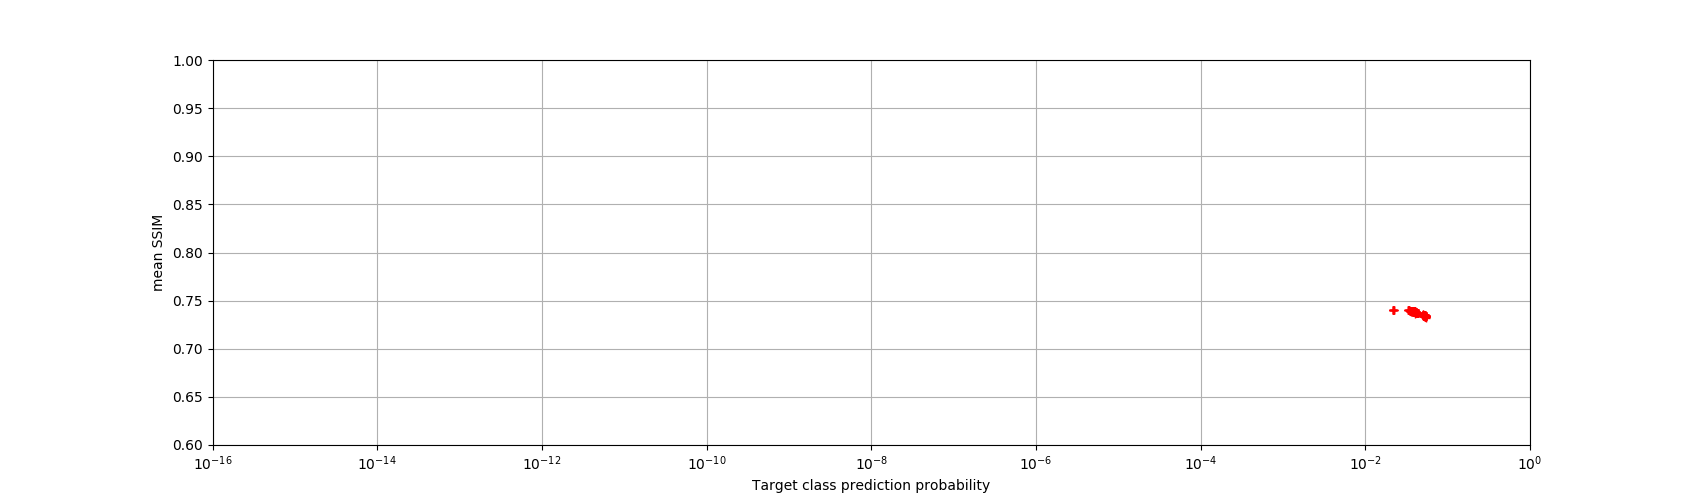

In [62]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(17,5))
# fig.tight_layout()

ax.set_xlim(0.0000000000000001, 1)
ax.set_xlabel('Target class prediction probability')
ax.set_ylim(0.6, 1)
ax.set_ylabel('mean SSIM')
ax.set_xscale('log')
ax.grid(axis='both')

callbacks = [GAStatus(fig), MultiObjectiveReport(ax)]

In [64]:
ga = GeneticAlgorithm(
    initializer=PrePopulationInit(first_run[0].individuals),
    operator_graph=graph,
    objective_fnc=Images2LabelObjectiveFnc(model, target_class, images),
    callbacks=callbacks
)

In [ ]:
final_pop, fitnesses, objectives = ga.run(population_size=256, generation_cap=1024)

In [56]:
first_run = final_pop, fitnesses, objectives

In [45]:
objectives.shape

(1024, 256, 2)

<IPython.core.display.Javascript object>


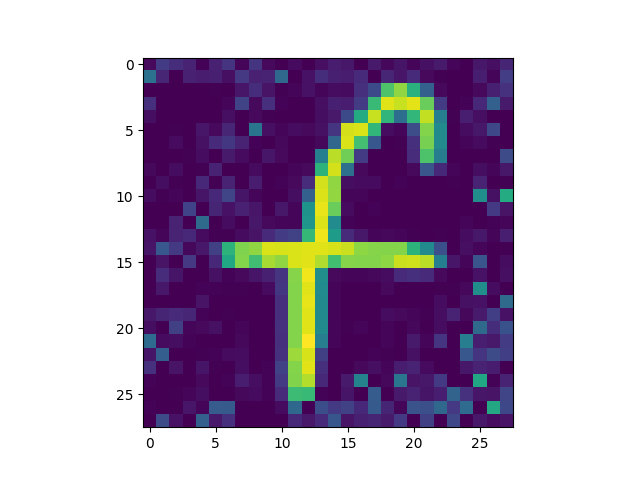

In [55]:
%matplotlib notebook

plt.imshow(final_pop.individuals[33] + images[3])